In [1]:
import numpy as np
import pandas as pd
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
import sys, os
from hsbmpy import plot_topic_size, get_max_available_L

In [2]:
directory="/home/jovyan/work/phd/datasets/gtex/10"
os.chdir(directory)
sys.path.append('/home/jovyan/work/phd/')

In [3]:
L = get_max_available_L(directory)

In [5]:
df = pd.read_csv("mainTable.csv", index_col=[0])

KeyboardInterrupt: 

# topic size

In [ ]:
for l in range(0,L+1):
    plot_topic_size(directory,l)

## Topic O

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=0,header=0)

In [ ]:
df_mv=pd.DataFrame(data=[df.mean(1), df.var(1),df.apply(lambda x: len([x[x>0]])/float(len(x)), 1)], index=['average', 'var', 'O']).transpose()
df_mv.head()

In [ ]:
for l in range(0,L+1):
    fig = plt.figure(figsize=(15,8))
    ax = fig.subplots(1,2)
    candles = get_candles(directory,l,df_mv,ax[0])
    candlestick2_ohlc(ax[0], candles['open'],candles['high'],candles['low'],candles['close'],width=0.6,colordown='b')
    ax[1].hist((np.array(candles['open'])+np.array(candles['close']))/2, weights=candles['size'], range=(-0.05,1.05), bins=10, histtype='step')
    ax[1].set_xlabel("$O_i", fontsize=18)
    plt.show()
    fig.savefig("%s/topic_Ocandles_level_%d.pdf"%(directory,l))

# Geneontology

In [ ]:
from geneontology import get_ontology_df, ensg_to_symbol
from tableanalyser import get_symbol
import gseapy as gs

In [ ]:
import importlib, geneontology,tableanalyser
importlib.reload(geneontology)
importlib.reload(tableanalyser)
from geneontology import get_ontology_df, ensg_to_symbol
from tableanalyser import get_symbol

In [ ]:
l=L-1
algorithm = "topsbm"
df_topics = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_topics.csv")
df_topics_smooth = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_word-dist.csv",index_col=0)
df_topics_smooth.index = [g[:15] for g in df_topics_smooth.index]

In [ ]:
def get_topic_over_thr(topic_name, q=0.75):
    topic = df_topics_smooth[topic_name]
    topic = topic[topic>0]
    topic = topic[topic>topic.quantile(q=q)]
    return topic.sort_values(ascending=False)

In [ ]:
df_symbols= pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_ensembl_id&col=md_ensembl_id&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", index_col=[0], sep='\t')

In [ ]:
def get_sea():
    for g in df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]:
        yield get_symbol(g)

In [ ]:
with open("gback.txt",'w') as f:
    list(map(lambda x: f.writelines(x+'\n')if len(x)>1 else None, get_sea()))
    
with open("gback_ensg.txt",'w') as f:
    list(map(lambda x: f.writelines(x[:15]+'\n')if len(x)>1 else None, df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]))

In [ ]:
gs.get_library_name()

In [ ]:
#https://www.gsea-msigdb.org/gsea/downloads.jsp
gene_sets = ['GO_Molecular_Function_2018',
             'GO_Biological_Process_2018',
             'GO_Cellular_Component_2018',
             'Human_Phenotype_Ontology',
             'WikiPathways_2019_Human',
             '/home/jovyan/work/phd/MSigDB/c1.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c2.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c3.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c4.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c5.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c6.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c7.all.v7.1.symbols.gmt',
            ]

In [ ]:
threshhold = 5e-1
cutoff = 5e-1
background = len([g for g in get_sea()])
os.system("mkdir -p gsea")
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1), index_col=[0])
        print(topic)
    except:
        try:
            #gene_list = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
            gene_list = ensg_to_symbol(get_topic_over_thr(topic).index)
            print(topic)
            enriched_topic = get_ontology_df(gene_list, cutoff=cutoff, threshhold = threshhold, gene_sets = gene_sets, background=background)
            enriched_topic = enriched_topic.sort_values(by=['Adjusted P-value'], ascending=True)[:20]
            enriched_topic.to_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1))
        except:
            print(*sys.exc_info())
            continue
    print(enriched_topic)

In [ ]:
topic_pvalues = []
topic_gos = []
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("%s/gsea/gsea_level_%d_topic_%d.csv"%(directory,l,itopic+1))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
            for goc in enriched_topic['Gene_set'][:10].unique():
                topic_gos.append(goc)
        print(topic)
    except:
        print("error", sys.exc_info()[0])

In [ ]:
fig = plt.figure()
x = np.arange(1,1+len(topic_pvalues))
c, _, _ = plt.hist(topic_pvalues, histtype='step', lw=2)
plt.plot([-np.log10(0.05) for _ in np.linspace(1,10,num=10)],np.arange(0,np.max(c)+5,(np.max(c)+5)/10), ls='--', lw=5, label="$\\alpha=0.05$")
plt.xlabel('-log(P-value)', fontsize=16)
plt.ylabel("number of topics")
#plt.ylim(0,0.055)
#plt.yscale('log')
plt.legend(fontsize=16)
fig.savefig("%s/pvaluescrosstopic(%d).png"%(directory,l))

In [ ]:
fig = plt.figure(figsize=(20,10))
gos, goscounts = np.unique(topic_gos,return_counts=True)
plt.barh(["\n".join(wrap(str(l).replace('_',' '),20)) for l in gos], goscounts)
plt.yticks(fontsize=15)
plt.show()
fig.savefig("%s/pvaluecategories(%d).pdf"%(directory,l))

# WGCNA vs hSBM

In [4]:
from scipy.stats import hypergeom
from sklearn.metrics import v_measure_score
import seaborn as sns
sns.set_context('paper')

In [84]:
hsbm_list_topics = pd.read_csv("topsbm/topsbm_level_3_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

In [6]:
hsbm_list_topics = pd.read_csv("topsbm-log/topsbm-log_level_2_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_log_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_log_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

In [7]:
wgcna_list = pd.read_csv("wgcna/wgcna_level_0_word-dist.csv", index_col=0).apply(pd.Series.idxmax,axis=1)
wgcna_list.index = [g[:15] for g in wgcna_list.index]

In [ ]:
tm_list = pd.read_csv("tm/tm_level_0_word-dist.csv", index_col=0).apply(pd.Series.idxmax,axis=1)

In [78]:
lda_list_topics = pd.read_csv("lda/lda_level_2_topics.csv")
gene_list = lda_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
lda_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in lda_list_topics.columns:
    lda_list[lda_list.index.isin([g[:15] for g in lda_list_topics[topic].dropna()])]=topic
lda_list=lda_list.reset_index().drop_duplicates("index").set_index("index")
lda_list=pd.Series(index=lda_list.index, data=lda_list.values.ravel())

In [90]:
list_1 = lda_list
list_2 = wgcna_list

first_name = "lda"
last_name = "wgcna"

#to uniform
list_1 = list_1[list_1.index.isin(list_2.index)]
list_2 = list_2[list_2.index.isin(list_1.index)]

In [91]:
population_size = len(list_1[list_1.index.isin(list_2.index)])
pop_successes = {module:len(list_2[list_2==module]) for module in list_2.unique()}
sample_sizes = {topic:len(list_1[list_1==topic]) for topic in list_1.unique()}
num_successes = pd.DataFrame(index=list_1.unique(), columns=list_2.unique()).fillna(0)
for g in list_2.index:
    if g in list_1.index:
        num_successes.at[list_1[g],list_2[g]]+=1
num_successes.shape

(13, 6)

In [92]:
df_cmap=pd.DataFrame(index=["Topic %d"%(d+1) for d in range(len(list_1.unique()))],
                     columns=["Topic %d"%(d+1) for d in range(len(list_2.unique()))]).fillna(0.5)
if "wgcna" in last_name:
    df_cmap.columns=num_successes.columns
for module, module_successes in zip(df_cmap.columns, num_successes.columns):
    for topic, topic_successes in zip(df_cmap.index, num_successes.index):
        x = num_successes.at[topic_successes,module_successes].astype(int) # number of successes
        M = population_size # pop size
        k = pop_successes[module_successes] # successes in pop
        N = sample_sizes[topic_successes] # sample size
        pval = hypergeom.sf(x-1, M, k, N)
        df_cmap.at[topic,module]=-np.log10(float(pval))

In [93]:
df_cmap[df_cmap<2]=0

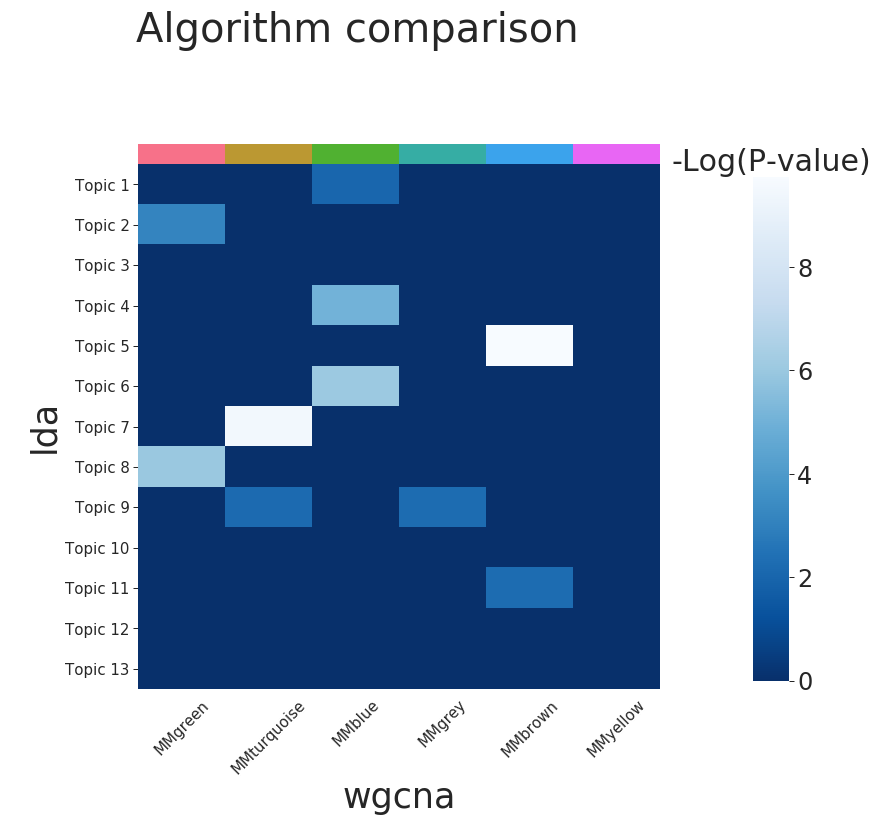

In [94]:
#df_cmap = df_cmap.sort_values(by=[c for c in df_cmap.columns], axis=0, ascending=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)
#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

cm = sns.clustermap(df_cmap, 
                    row_cluster=False, 
                    col_cluster=False, 
                    metric='euclidean', 
                    vmin=0, 
                    cmap='Blues_r', 
                    col_colors=network_col,
                    mask=False,
                   cbar_pos=(1.05,0.05,0.05,0.7))

ax = cm.ax_heatmap
ax.tick_params(labelsize=15)

ax.set_ylabel(first_name, fontsize=35)
ax.set_xlabel(last_name, fontsize=35)
ax.set_xticklabels(df_cmap.columns, rotation=45)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

cax = cm.ax_cbar
cax.tick_params(labelsize=24)
cax.set_title("-Log(P-value)", fontsize=30)

#plt.tight_layout()

cm.fig.suptitle('Algorithm comparison', fontsize=40)
cm.savefig(f"topics_logp_{first_name}_{last_name}.pdf")
plt.show()

In [ ]:
print("hsbm - lda %.3f"%v_measure_score(list_1, list_2))

In [ ]:
list(map(print,list_1[list_1=="Topic 39"].index))

In [ ]:
print("hsbm - wgcna %.3f"%v_measure_score(hsbm_list, wgcna_list))
print("hsbm - tm %.3f"%v_measure_score(hsbm_list.reindex_like(tm_list), tm_list))
print("tm - wgcna %.3f"%v_measure_score(tm_list, wgcna_list.reindex_like(tm_list)))
print("hsbm - lda %.3f"%v_measure_score(hsbm_list, lda_list.reindex_like(hsbm_list)))